# RQAOA workflow 

We demonstrate the various modes RQAOA can be used to solve problems in OpenQAOA.

Current version:

  - Supports customizable elimination schedules - including vanilla (original) version.
  - Supports adaptive elimination schedule.
  - Only supports X mixer. Soon to add XY mixers for various topologies.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import networkx as nx
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.linewidth'] = 2

from openqaoa.workflows.optimizer import RQAOA, QAOA
from openqaoa.problems.problem import MinimumVertexCover, PUBO, Encoding
from openqaoa.utilities import ground_state_hamiltonian
from openqaoa.qaoa_parameters import Hamiltonian

## Problem: Minimum Vertex Cover of an N = 10 ring

In [2]:
# Number of qubits
n_qubits = 10

# Ring graph
G = nx.circulant_graph(n_qubits,[1])

# Minimum vertex cover parameters
field = 1.0
penalty = 10

# Define problem instance
vc = MinimumVertexCover(G,field = field,penalty = penalty).get_pubo_problem()

## Set up the QAOA properties for the recursive process

In [26]:
# Define the QAOA properties
q = QAOA()
q.set_circuit_properties(p=1, param_type='standard', init_type='ramp', mixer_hamiltonian='x')

# q.set_device_properties(device_location='qcs', device_name='Aspen-11', cloud_credentials = qcs_credentials)
# q.set_backend_properties(n_shots=100, cvar_alpha=1)
# q.set_classical_optimizer(method='cobyla', maxiter=200)

### Vanilla (original) version

In the original formulation, a single spin is removed from the system at a time.

In [27]:
# Define RQAOA instance
R = RQAOA(qaoa = q, rqaoa_type = 'custom')

In [28]:
# Set parameters for RQAOA, in this case only the final cutoff value
R.set_rqaoa_parameters(n_cutoff = 3)

In [29]:
# Compile problem instance on RQAOA
R.compile(vc)

	  ### Summary ###
OpenQAOA has ben compiled with the following properties
Solving QAOA with  vectorized  on  local
Using p=1 with standard parameters initialsied as ramp
OpenQAOA will optimize using cobyla, with up to 100 maximum iterations


In [30]:
# Solve problem with RQAOA
R.optimize()

In [31]:
# Extract results
R.result

{'solution': {'1010101010': 5.0},
 'classical output': {'cost min': -3.5, 'opt strings': [array([1, 0, 0])]},
 'elimination rules': [{(0, 1): -1.0},
  {(None, 1): -1.0},
  {(None, 2): -1.0},
  {(3, 4): -1.0},
  {(None, 1): 1.0},
  {(1, 2): -1.0},
  {(None, 2): -1.0}],
 'schedule': [1, 1, 1, 1, 1, 1, 1],
 'total steps': 7}

### Custom method

OpenQAOA also enables the possibility of manually selecting how do we want the elimination procedure to take place. This is done via the parameter $steps$. If $steps$ is an integer number, then at each step that number of eliminations will take place. If $steps$ is a list, then the procedure will follow the list to complete the eliminations.

In [32]:
# Define RQAOA instance
R = RQAOA(rqaoa_type = 'custom')

In [38]:
# Set parameters for RQAOA, in this case only the final cutoff value

# Fixed step
# R.set_rqaoa_parameters(steps=2,n_cutoff = 3)

# Schedule
schedule = [1,2,3,4,5]
R.set_rqaoa_parameters(steps=schedule,n_cutoff = 3)

In [39]:
# Compile problem instance on RQAOA
R.compile(vc)

	  ### Summary ###
OpenQAOA has ben compiled with the following properties
Solving QAOA with  vectorized  on  local
Using p=1 with standard parameters initialsied as ramp
OpenQAOA will optimize using cobyla, with up to 100 maximum iterations


In [40]:
# Solve problem with RQAOA
R.optimize()

In [41]:
# Extract results
R.result

{'solution': {'1011011110': 7.0, '0111011101': 7.0, '1011011101': 7.0},
 'classical output': {'cost min': -5.0,
  'opt strings': [array([1, 1, 0]), array([0, 0, 1]), array([1, 0, 1])]},
 'elimination rules': [{(0, 1): -1.0},
  {(None, 1): -1.0, (None, 2): -1.0},
  {(None, 2): -1.0, (None, 3): -1.0, (None, 4): -1.0},
  {(None, 1): 1.0}],
 'schedule': [1, 2, 3, 1],
 'total steps': 4}

### Adaptive method

In our adaptive version, the top $n_{max}+1$ statistical quantities are selected, and the average between them is computed. All quantities lying above average are used for elimination, enabling an adaptive selection of the elimination step, with maximum value $n_{max}$. Note that $n_{max} = 1$, corresponds to vanilla RQAOA!

In [42]:
# Define RQAOA instance
R = RQAOA(rqaoa_type = 'adaptive')

In [43]:
# Set parameters for adaptive RQAOA, the maximum number of eliminations allowed and final cutoff value
R.set_rqaoa_parameters(n_cutoff = 3, n_max = 4)

In [44]:
# Compile problem instance on RQAOA
R.compile(vc)

	  ### Summary ###
OpenQAOA has ben compiled with the following properties
Solving QAOA with  vectorized  on  local
Using p=1 with standard parameters initialsied as ramp
OpenQAOA will optimize using cobyla, with up to 100 maximum iterations


In [45]:
# Solve problem with RQAOA
R.optimize()

In [46]:
# Extract results
R.result

{'solution': {'1010101010': 5.0, '0101010101': 5.0},
 'classical output': {'cost min': -7.5,
  'opt strings': [array([1, 1, 0]), array([0, 0, 1])]},
 'elimination rules': [{(0, 1): -1.0, (0, 2): 1.0, (0, 3): -1.0, (0, 9): -1.0},
  {(0, 1): 1.0, (0, 2): -1.0, (0, 5): 1.0}],
 'schedule': [4, 3],
 'total steps': 2}

## Problem: Sherrignton-Kirkpatrick, with $J_{ij} = \pm 1$ and $N = 10$, using RQAOA

In [47]:
# Number of qubits
n_qubits = 10

# Define fully connected terms
terms = [(i,j) for j in range(n_qubits) for i in range(j)]

# Define random weights
seed = 42
np.random.seed(seed)
weights = [(-1)**np.round(np.random.random()) for _ in range(len(terms))]

# Define PUBO problem
sk = PUBO(n_qubits,terms,weights, encoding=Encoding.ISING_ENCODING)

No constant term found


In [48]:
# Obtain exact solution for comparison

hamiltonian = Hamiltonian.classical_hamiltonian(terms,weights,constant = 0)
exact_energy, ground_state_strings = ground_state_hamiltonian(hamiltonian)
print(f'The exact energy is {exact_energy} and the solutions are {ground_state_strings}')

The exact energy is -17.0 and the solutions are ['1101100000', '1110011010', '0001100101', '0010011111']


In [51]:
# Define RQAOA instance
R = RQAOA(rqaoa_type = 'adaptive')

# Set parameters for adaptive RQAOA, the maximum number of eliminations allowed and final cutoff value
n_cutoff = 3
n_max = 3
R.set_rqaoa_parameters(n_cutoff = n_cutoff, n_max = n_max)

# Compile problem instance on RQAOA
R.compile(sk)

# Solve problem with RQAOA
R.optimize()

# Extract results
result = R.result
solutions = result['solution']

states = list(solutions.keys())
energy = list(solutions.values())[0]

print(f'\n\nThe solution found by Ada-RQAOA for nmax = {n_max} is energy = {energy} and ground states = {states}')
print(f'The Approximation Ratio is {energy/exact_energy}')

	  ### Summary ###
OpenQAOA has ben compiled with the following properties
Solving QAOA with  vectorized  on  local
Using p=1 with standard parameters initialsied as ramp
OpenQAOA will optimize using cobyla, with up to 100 maximum iterations


The solution found by Ada-RQAOA for nmax = 3 is energy = -17.0 and ground states = ['1101100000', '0010011111']
The Approximation Ratio is 1.0


### Extensive simulation

Performed simulations on 100 instances of $n_{q} = 12$ Sherrington-Kirkpatrick model with the adaptive method taking $n_{\textrm{max}} = [1,2,3,6]$, $p = 1$, and a cutoff value of $n_{cutoff} = 3$. The parametrization was $\textit{standard}$ and initialization $\textit{ramp}$. Classical optimization was performed with COBYLA. The whole process took ~12 mins.

In [52]:
# # Load data
# path = 'SK_AppRat_rqaoa_vs_qaoa_nq12_p1_ncut3_nsamples100_cobyla200.txt'
# infile = open(path, "rb")
# data = pickle.load(infile)

# # Exctract variables
# QAOA_rat_samples = data['QAOA_rat_samples']
# RQAOA_rat_samples = data['RQAOA_rat_samples']

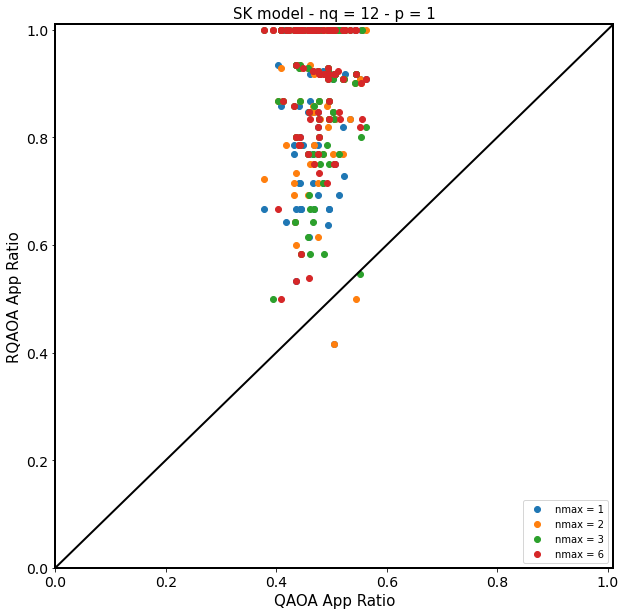

In [53]:
# fig,ax = plt.subplots(1,1, figsize = (10,10))

# Nmax = [1,2,3,6]

# x = np.linspace(0,2,101)
# ax.plot(x,x,color = 'black', linewidth = 2.0)
# for idx,n_max in enumerate(Nmax):
        
#     ax.scatter(QAOA_rat_samples,RQAOA_rat_samples[idx], label = f'nmax = {n_max}')

# ax.set_xlim([0.0, 1.01])
# ax.set_ylim([0.0, 1.01])
# ax.legend(loc = 'lower right')

# ax.set_title(f'SK model - nq = 12 - p = 1', fontsize = 15)
# ax.set_xlabel(f'QAOA App Ratio', fontsize = 15)
# ax.set_ylabel(f'RQAOA App Ratio', fontsize = 15)

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.show()